In [193]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import math
import plotly 
plotly.tools.set_credentials_file(username='AlexForVA', api_key='zD1O0M48SU15XWMxDNSa')
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [56]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 80%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 90%; }
</style>
"""))

## Loading and wrangling of our dataset

In [3]:
# load the dataset
# crimes = pd.read_csv('crime_data.csv')
crimes = pd.read_pickle('cleaned_crime_dump')

### Data cleaning, formatting, and dimensionality reduction

In [ ]:
# # Remove unused columns
crimes.drop(['Reporting District','Crime Code 1', 'Crime Code 2', 'Crime Code 3', 
             'Crime Code 4', 'Address', 'Cross Street'], axis=1, inplace=True)


# removes rows containing an unidentifiable status code and rows which do not contain a value
crimes.drop(crimes[(crimes['Status Code']=='CC') | (crimes['Status Code']=='13')
                  | (crimes['Status Code']=='19') | (crimes['Status Code']=='TH')].index, inplace=True)
crimes.drop(crimes[crimes['Status Code'].isnull()].index, inplace=True)

# remove rows where there is no premise code
crimes.drop(crimes[crimes['Premise Code'].isnull()].index, inplace=True)

# to better handle entries where the victim age is not given, we introduce a default value of -1
crimes['Victim Age'].fillna(-1, inplace=True)

# remove victims with a strange sex code and rows which do not contain a value
crimes.drop(crimes[(crimes['Victim Sex']=='H') | (crimes['Victim Sex']=='-')].index, inplace=True)
# crimes.drop(crimes[crimes['Victim Sex'].isnull()].index, inplace=True)
crimes['Victim Sex'].fillna('Not Given', inplace=True)

# remove victims with '-' as victim descent and rows which do not contain a value
crimes.drop(crimes[(crimes['Victim Descent']=='-')].index, inplace=True)
# crimes.drop(crimes[crimes['Victim Descent'].isnull()].index, inplace=True)
crimes['Victim Descent'].fillna('Not Given', inplace=True)

# If the Weapon Code is not given, this might either indicate that it is unknown or that there was no weapon
crimes['Weapon Used Code'].fillna(222.0, inplace=True)
crimes['Weapon Description'].fillna('Unknown/No Weapon', inplace=True)

# Drop rows without crime code description
crimes.drop(crimes[crimes['Crime Code Description'].isnull()].index, inplace=True)

# Drop rows without premise description ~3300
crimes.drop(crimes[crimes['Premise Description'].isnull()].index, inplace=True)

#convert date columns to date type (this takes a while)
crimes['Date Occurred'] = pd.to_datetime(crimes['Date Occurred'])
crimes['Date Reported'] = pd.to_datetime(crimes['Date Reported'])

# drop crimes that happend or where reported in 2018
crimes.drop(crimes[crimes['Date Occurred'].dt.year==2018].index, inplace=True)
crimes.drop(crimes[crimes['Date Reported'].dt.year==2018].index, inplace=True)

# Transform location column into two columns longitude and latitude. Location will be removed later on
locations = crimes['Location '].str.replace('(', '')
locations = locations.str.replace(')', '')
locations = locations.str.split(',')
longitude = []
latitude = []
for i, item in enumerate(locations):
    longitude.append(float(item[0]))
    latitude.append(float(item[1]))
    
crimes['Longitude'] = longitude
crimes['Latitude'] = latitude

crimes.drop(['Location '], axis=1, inplace=True)

# rows which contain longitude or latitude 0 will be removed, as they are not in LA 
crimes.drop(crimes[crimes['Longitude'] == 0].index, inplace=True)
crimes.drop(crimes[crimes['Latitude'] == 0].index, inplace=True)



# create a column with age groups
def map_age_group(x):
    
    if x==-1:
        return 'X'
    if x<18:
        return '10-18'
    if x<25:
        return '18-25'
    if x<35:
        return '25-35'
    if x<50:
        return '35-50'
    if x<70:
        return '50-70'
    if x<90:
        return '70-90'    

    return '90-100'

crimes['Victim Age Group']=crimes['Victim Age'].map(lambda x: map_age_group(x))


# map military times to full hour military times
def map_times(x):
    times = [30, 130, 230, 330, 430, 530, 630, 730, 830, 930, 1030, 1130, 
             1230, 1330, 1430, 1530, 1630, 1730, 1830, 1930, 2030, 2130, 2230, 2330]
    
    for i, time in enumerate(times):
        if x <= time:
            x = time - 30
            break
    
    if x > 2330:
        x=0
    return x

crimes['Time Occurred'] = crimes['Time Occurred'].map(lambda x: map_times(x))



## Analyzing the dataset using descriptiv statistics

As we have a quite big dataset with about 1.6 million crime incidents from 2010 to 2017, we want to focus on some attributes, which we think could be interesting. In the following we list the attributes that we want to take a closer look at, and some questions that came in to our mind, which we want to address. Some of these questions are already concerned with the correlation between certain attributes and will be treated in a seperate section.

- **Date Occurred** this attribute indicates when a crime incident has happend.
    - Is the crime rate in general increasing or decreasing over the years?
    - Is there a day on which more crimes happened?
   
   
- **Time Occurred** the time (in terms of hours and minutes) when a crime incident has happend. 
    - Is there a general trend when crimes occurr (maybe at night)?
    - Is there a relationship between specific types of crimes and time?
    
    
- **Crime Code/Description** the code identifying a crime type and its description (e.g. 310 Burglary)
    - What are the most common crimes?
    - Is there a relationship between the type of crimes and the date/time they are occurring?
    
    
- **Victim Age** the age of the victims (number between 10 and 99)
    - Is there an age group that is more likely to be the victims of a crime?
    - Is the age distribution changing over the years?


- **Victim Sex** the sex of the victims (Male, Female, Unknown)
    - Are males/females more often the victims of a crime?
    - Is there a relationship between certain types of crimes and the sex?
    
    
- **Victim Descent** the ethnic background of the victims (e.g. White, Black, Hispanic etc.)
    - Are people with a certain background more likely to be the victim of specific crimes?
    - How is age/sex and descent related in terms of specific crimes?
  
 

- **Location** the location where the crime occurred rounded to the nearest 100 block (longitude and latitude)
    - Are there some general crime hotspots? (visualization on a map)
    - If there are hotspots, did they change over time?
  
    

### A closer look on the attribute 'Date Occurred'

#### Crimes over the years
At first, we want to address how the crime rate is changing over the years. To do so we aggregate our attribute **Date Occurred** for each year and we will plot it by using a simple line chart. In this way we can see how the absolute number of crimes is increasing/decreasing over time.

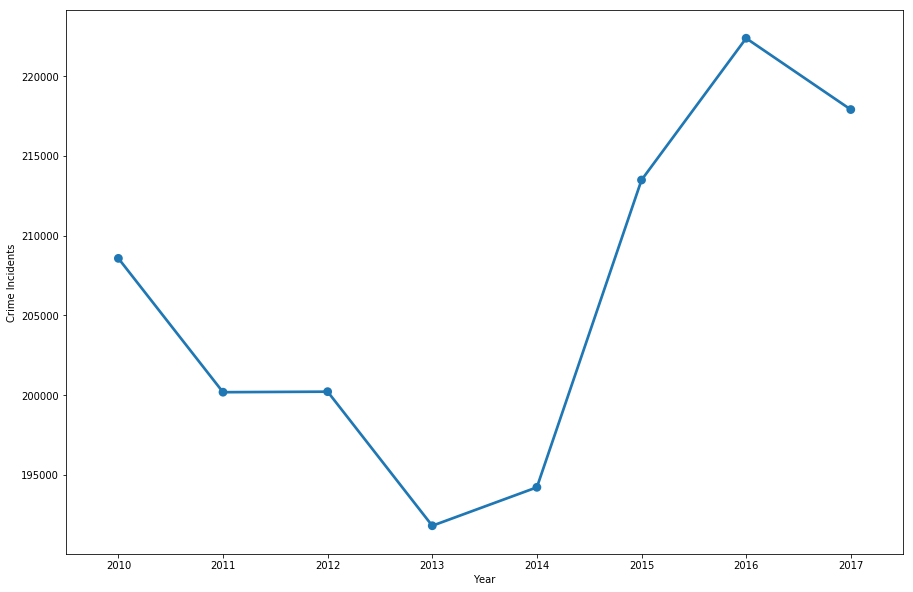

In [5]:
grouped_year = crimes.groupby([crimes['Date Occurred'].dt.year])
grouped_year = pd.DataFrame({'Crime Incidents' : grouped_year.size()}).reset_index()

plt.figure(figsize=(15,10))
ax = sns.pointplot(x = 'Date Occurred', y="Crime Incidents", data=grouped_year)
ax.set_xlabel('Year');

It seems that the number of crimes decreased from 2010 until 2013 and increased from 2013 until now.
Researching the overall crime rate in the US shows a similar trend, and there could be various economical and sociological reasons for this, which we cannot infer from our data.


#### Crimes and weekdays
The second thing we want to check is, if there is a certain day within the week where more crimes occurr. We do so in the same way as we have done befor, by grouping and using a line chart.

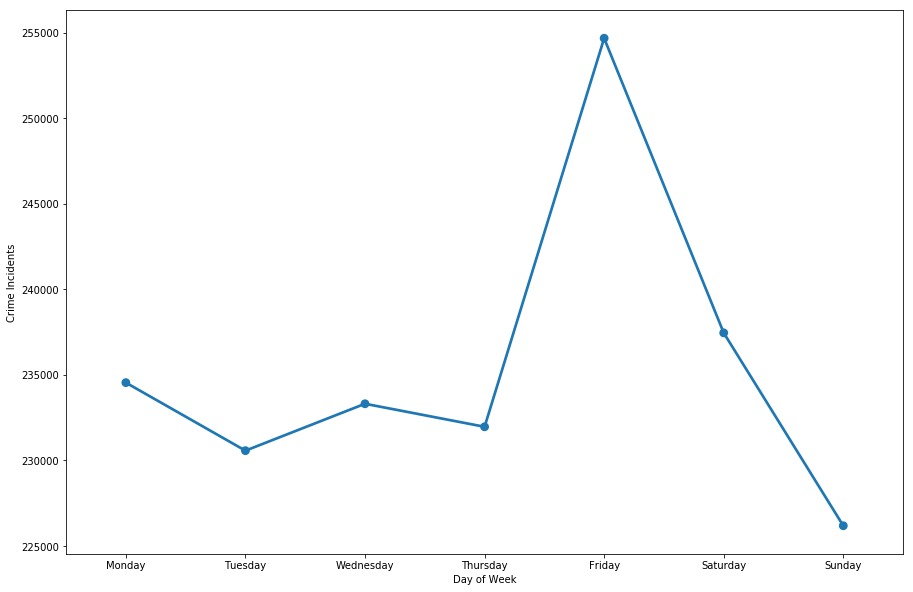

In [6]:
grouped_day = crimes.groupby([crimes['Date Occurred'].dt.weekday])
grouped_day = pd.DataFrame({'Crime Incidents' : grouped_day.size()}).reset_index()

plt.figure(figsize=(15,10))
ax = sns.pointplot(x="Date Occurred", y="Crime Incidents", data=grouped_day)
ax.set_xlabel('Day of Week')
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']);

The plot shows a noticable increase for crimes on friday compared to the other days. This is interessting and there could be several explanations. It could be possible that there are more cases of battery on a friday as people are going out to pubs/bars/clubs, and drunk people are more likely to be involved in fights. It could also be the case that quite a lot people are away over the weekend which leaves there homes empty and could thus attract thiefs.
To find out what the real reason for this peak is, we have to take a closer look on the other attributes, to see if there is a correlation between any of them and the day of the week, especially with respect to the type of crime.

### Analyzing the time when crimes are occurring

We want to know if there are certain times during a day, where crimes occurr more often. To analyse this, we 
map the time to full hours (14:30 will be mapped to 14:00 and 14:31 to 15:00). To see if there is a trend, we  will again use a simple line chart.

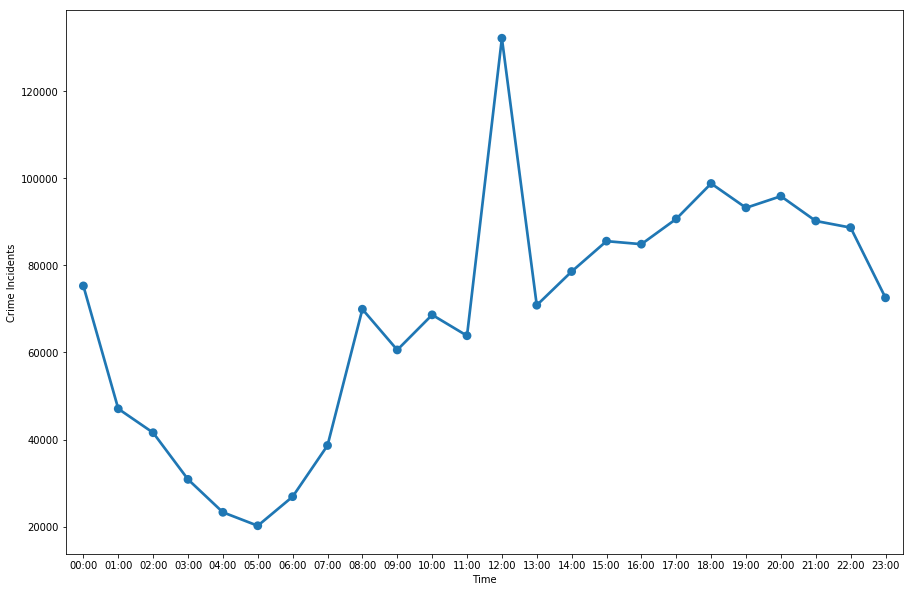

In [7]:

grouped_time = crimes.groupby('Time Occurred')
grouped_time = pd.DataFrame({'Crime Incidents' : grouped_time.size()}).reset_index()

plt.figure(figsize=(15,10))
ax = sns.pointplot(x="Time Occurred", y="Crime Incidents", data=grouped_time)
ax.set_xlabel('Time')

ax.set_xticklabels(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00',
                    '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']);

There is a significant and from our point of view a rather unplausible peak at 12 o'clock. 
Otherwise, one would also assume that crimes are usually more likely to happen during the night or very early in the morning, which however doesn't seem to be the case. It could be the case that various kinds of theft and burglary are happenin during the night, but that there are less of those compared to other type of crimes, which are maybe more likely to happen during the day. We will have to check this during our correlation analysis.


### What are the most common crimes
We want to know what the most common crimes in LA are. In order to do this, we will group the data by the columns *Crime Code* and *Crime Code Description*. This will give as the number of crime incidents for each type of crime, which we now compare in a bar chart. We restrict our selection to the 20 most common crimes to keep the visualization clear.

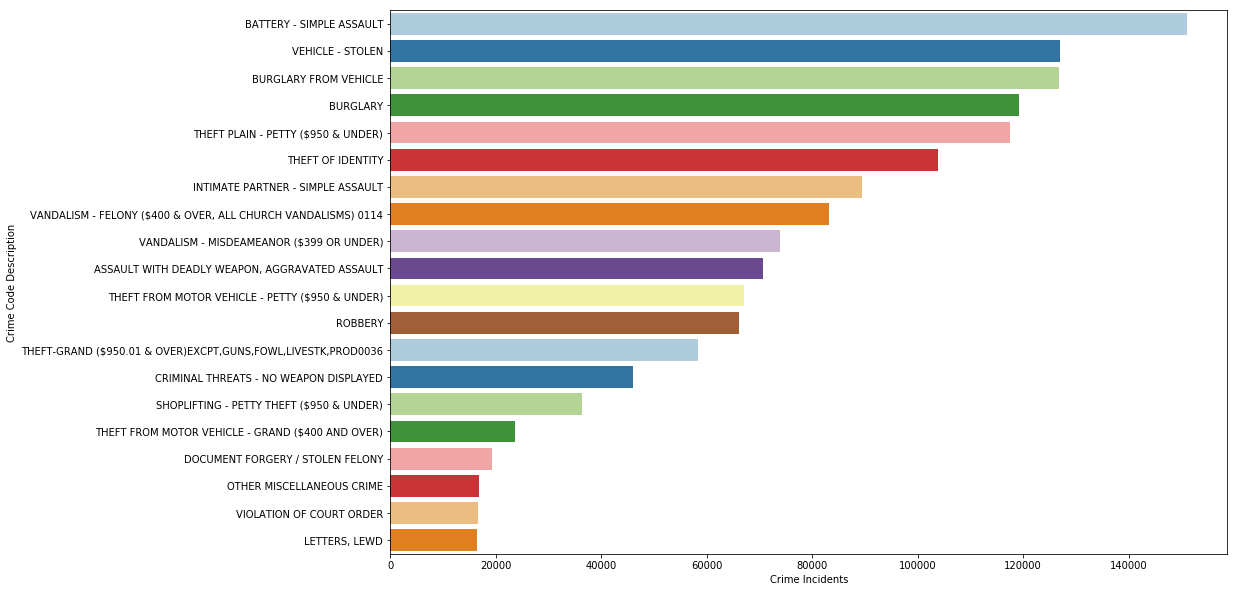

In [8]:
grouped_crimes = crimes[['Crime Code', 'Crime Code Description']].sort_values(['Crime Code']).groupby(['Crime Code', 'Crime Code Description'])

grouped_crimes = pd.DataFrame({'Crime Incidents' : grouped_crimes.size()}).reset_index().sort_values(ascending=False, by='Crime Incidents')

# color palette from color brewer http://colorbrewer2.org/
color_palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

plt.figure(figsize=(15,10))
sns.barplot(x='Crime Incidents', y='Crime Code Description', data=grouped_crimes.head(20), palette=color_palette);

Taking a closer look on the plot shows us, that Battery-Simple Assault is the most common crime with over 140000 incidents in 7 years, which means that there are on average more than 55 cases each day.<br>
This plot should just show the major crimes, however it will be more interesting to see if there is any correlation between the type of crime and another attribute like sex/age/descent or the time.

### Taking a closer look on the age distribution of the victims
We want to know how the age of the victims is distributed over the whole dataset. In order to do this we will use a histogram, general descriptiv statistics like mean and median, and we will also show a boxplot.
Furthermore, we will disregard those crime incidents where we mapped the age to -1, as this would distort our results

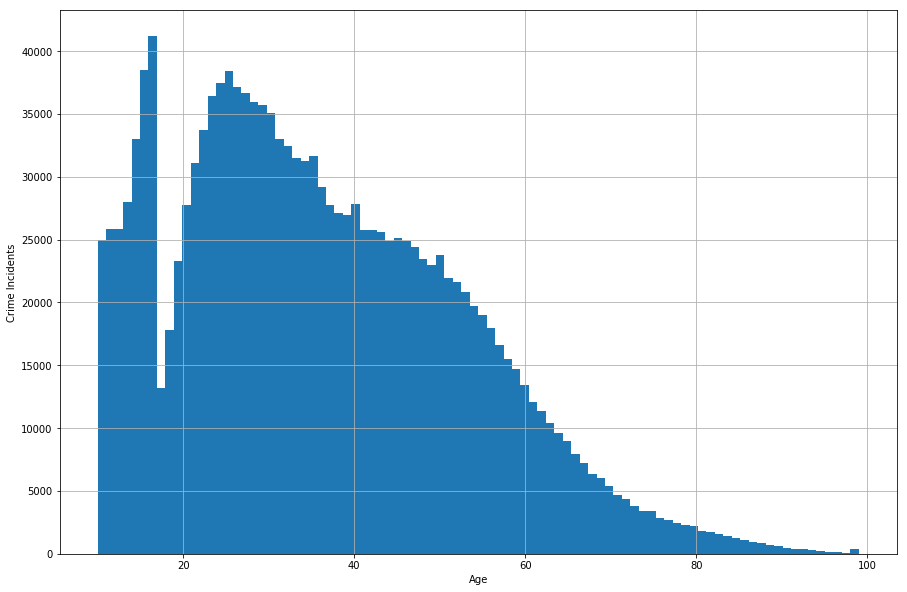

In [10]:
# we have an age range from 10 to 99, which yields 90 bins
ax = crimes[crimes['Victim Age']!=-1]['Victim Age'].hist(bins=90,figsize=(15,10))
ax.set_xlabel('Age')
ax.set_ylabel('Crime Incidents');

This distribution seems rather unusual, as the number of crime incidents from age 10 to approx. 16 do not really match to the remaining distribution. The sudden dip does not really make sense, but without further exploration we cannot really guess what the reason for this might be. We have to take a closer look onto these incidents with respect to other variables and maybe also see how this distribution is changing over time.

To further analyse the distribution we now calculate the mean and median age and we will also show a boxplot to better visualize in which age range most of the victims are.

Mean: 35.949010458716565
Median: 34.0


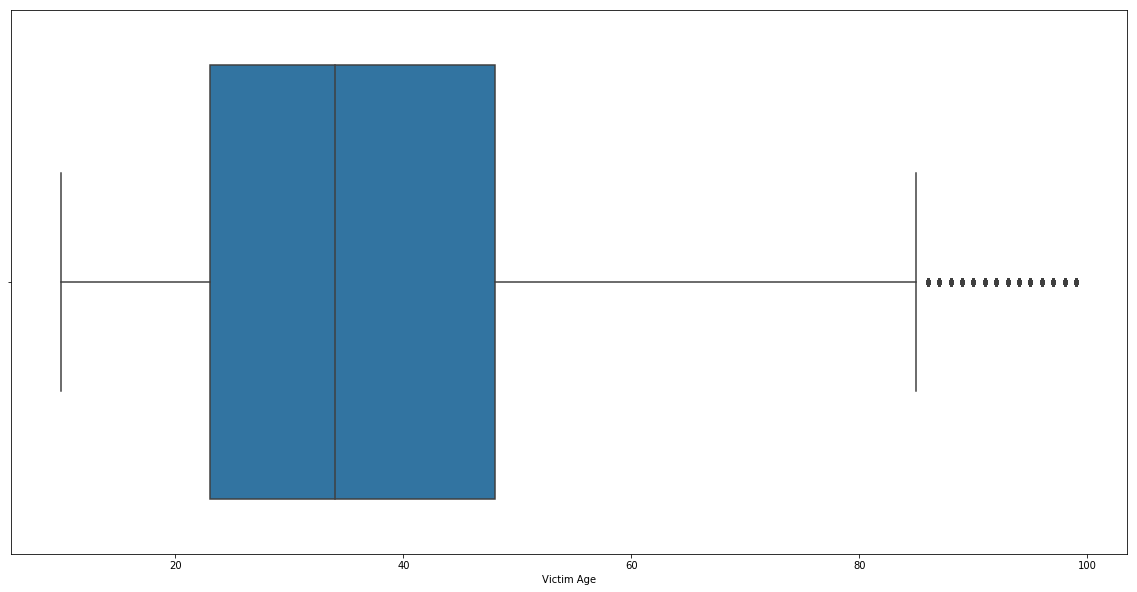

In [11]:
print('Mean: {}'.format(crimes[crimes['Victim Age']!=-1]['Victim Age'].mean()))
print('Median: {}'.format(crimes[crimes['Victim Age']!=-1]['Victim Age'].median()))

plt.figure(figsize=(20,10))
sns.boxplot(y=crimes[crimes['Victim Age']!=-1]['Victim Age'], orient='h');

If one would just analzye the boxplot, one wouldn't find anything strange. The plot looks reasonable, with a median around 34 and an IQR from approx. 23-50. However, to observe the strange behaviour, one would also need see a violin plot which further visualizes the distribution or a histogram like we have shown before.

### Sex and Crime or who is more often victim of a crime
We have three sex classes, male(M), female(F), unknown(X) and an additional class 'Not Given' that we have introduced. 
What we now want to know is which class is more often the victim of a crime. To compare those we will use a plain bar chart.

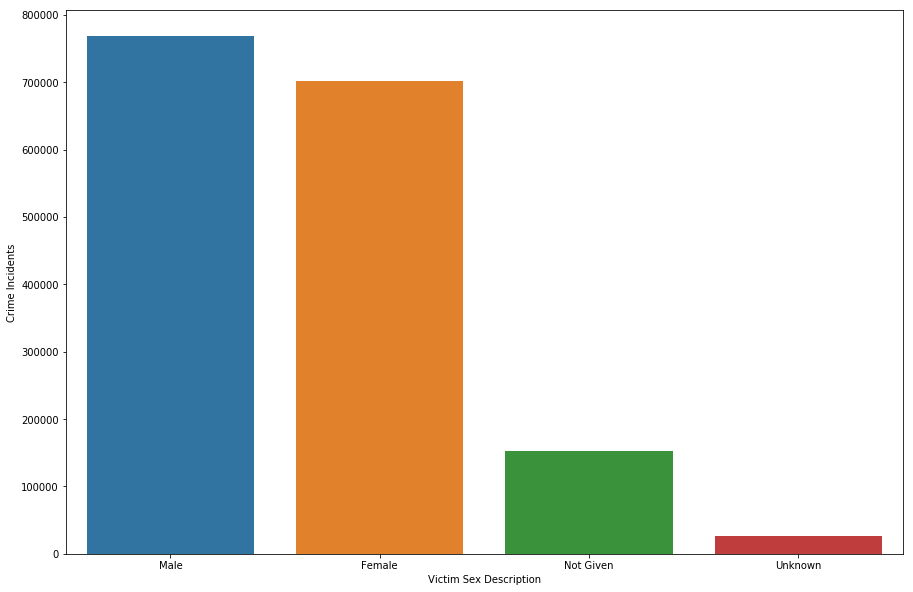

In [12]:
grouped_sex = crimes[['Victim Sex']].groupby(['Victim Sex'])
victim_sex_desc = [ 'Female', 'Male','Not Given', 'Unknown']
grouped_sex = pd.DataFrame({'Crime Incidents' : grouped_sex.size(), 'Victim Sex Description':victim_sex_desc}).reset_index()
grouped_sex = grouped_sex.sort_values(ascending=False, by='Crime Incidents')

plt.figure(figsize=(15,10))
sns.barplot(x='Victim Sex Description', y='Crime Incidents', data=grouped_sex);

While there is some difference between the number of male and female victims, however the absolute number is not too far apart. Quite noticeable however is the number of victims where no sex was given. One possible explanation could be that there are quite a lot of crimes where not a single person was the victim but e.g. a company or the property of a company.
We have to further explore this by looking at the crime types related to a non given victim sex.

### Ethnical background and crime victims
We want to know, if people with a certain ethnical background are more likely to be victims of a crime.
To do so, we will again use a barplot, however from preliminary experiments we know that there are several descent-classes with a small number of incidents, which would distort the plot. We therefore decided to only show the seven major classes.

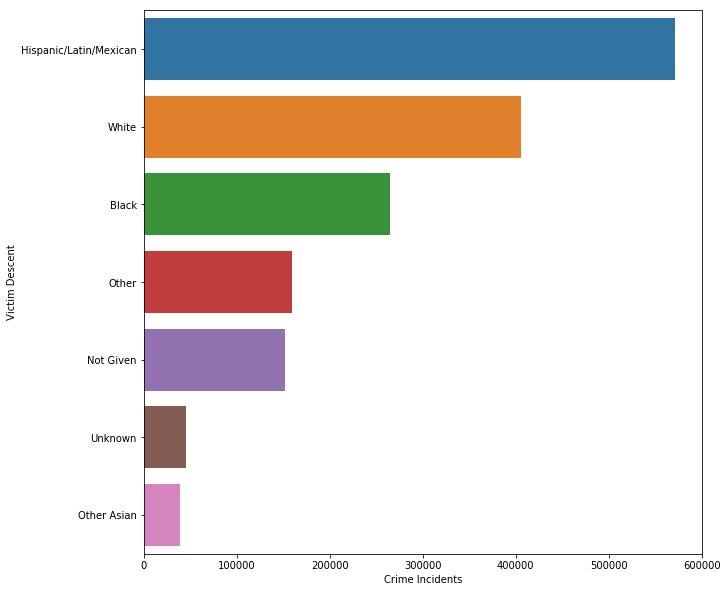

In [203]:
grouped_descent = crimes[['Victim Descent']].sort_values(['Victim Descent']).groupby(['Victim Descent'])
victim_descent_desc = ['Other Asian', 'Black','Chinese','Cambodian','Filipino','Guamanian',
                       'Hispanic/Latin/Mexican','American Indian/Alaskan Native', 'Japanese', 
                       'Korean', 'Laotian','Not Given','Other', 'Pacific Islander', 'Samoan', 'Hawaiian', 
                       'Vietnamese', 'White', 'Unknown', 'Asian Indian']

grouped_descent = pd.DataFrame({'Crime Incidents' : grouped_descent.size(), 'Victim Description': victim_descent_desc}).reset_index()
grouped_descent = grouped_descent.sort_values('Crime Incidents', ascending=False)

plt.figure(figsize=(10, 10))
ax = sns.barplot(x='Crime Incidents', y='Victim Description', data=grouped_descent.head(7))
ax.set_ylabel('Victim Descent');

From the bar chart we can see that the three most common victim descents are Hispanic/Latin/Mexican, White and Black.
The difference between Hispanic/Latin/Mexican to Black is almost as big as the number of incidents involving people falling into the category Black. However, one has to be careful with these numbers, as we would have to further consider the whole population of LA. A quick research on the web, tells us that Hispanics/Latinos account for about 47.5% of the whole population whereas Black/African American account for approx. 10%. So, one cannot just conclude that Hispanics are just more likely to be the victims of the crime, as there are also more hispanic people living in LA, which could be the reason that they are more involved in crimes.

### Where are crimes usually happening


In [281]:
AGGREGATION_BORDER = 20000
LEVEL_OF_AGGREGATION = 2 # number of number after comma
def aggregateCrimes(temp):
    # round longitude and latitude to aggregate 
    temp = temp.copy()
    levelOfAggregation = LEVEL_OF_AGGREGATION
    temp['RoundedLongitude'] = temp['Longitude'].round(levelOfAggregation)
    temp['RoundedLatitude'] = temp['Latitude'].round(levelOfAggregation)
    
    aggregateDf = temp.groupby(['RoundedLongitude', 'RoundedLatitude']).size().reset_index(name='Counts')
    aggregateDf['Sizes'] = aggregateDf['Counts'].apply(math.log)
    aggregateDf['Sizes'] *= 3
    aggregateDf['Sizes'] += 8
    aggregateDf['Counts'] = aggregateDf['Counts'].astype(str) + ' crimes'
    return aggregateDf

def filterEntireDS(yearsFromTo, areaNames, crimeCodes, weapons, victimAgeFromTo):
    temp = crimes[(crimes['Date Occurred'].dt.year >= yearsFromTo[0]) & (crimes['Date Occurred'].dt.year <= yearsFromTo[1])]
    temp = temp[temp['Area Name'].isin(areaNames)]
    temp = temp[temp['Crime Code Description'].isin(crimeCodes)]
    temp = temp[temp['Weapon Description'].isin(weapons)]
    return temp[(temp['Victim Age'] >= victimAgeFromTo[0]) & (temp['Victim Age'] <= victimAgeFromTo[1])] 

# Widgets
yearWidget = widgets.IntRangeSlider(
    value=[2010, 2017],
    min=2010,
    max=2017,
    step=1,
    description='Years:',
    disabled=False,
    orientation='horizontal',
    readout=False,
    readout_format='d',
)

# area name
areaNames = sorted(crimes['Area Name'].unique().tolist())

areaNameWidget = widgets.SelectMultiple(
    options=areaNames,
    rows=10,
    description='Area Name:',
    disabled=False,
    readout=False
)

# victim ages
victimAges = sorted(crimes['Victim Age'].unique().tolist())

victimAgeWidget = widgets.IntRangeSlider(
    value=[min(victimAges), max(victimAges)],
    min=min(victimAges),
    max=max(victimAges),
    step=1,
    description='Victim Age:',
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

# crimes
crimeCodes = sorted(crimes['Crime Code Description'].unique().tolist())

crimeCodeWidget = widgets.SelectMultiple(
    options=crimeCodes,
    rows=10,
    description='Crime Code:',
    disabled=False
)

# weapons
weapons = sorted(crimes['Weapon Description'].unique().tolist())

weaponWidget = widgets.SelectMultiple(
    options=weapons,
    rows=10,
    description='Weapon:',
    disabled=False
)


mapbox_access_token = 'pk.eyJ1IjoiYWxleHVzZXJmb3J2YSIsImEiOiJjamNkbzRicjkweHl2MndudHhjNnJ4aWN3In0.AaVHAeAvLxrOhveZHj3CvA'

# initially aggregate all data
aggregateDf = aggregateCrimes(crimes)

data = Data([
    Scattermapbox(
        lat=aggregateDf['RoundedLongitude'],
        lon=aggregateDf['RoundedLatitude'],
        text=aggregateDf['Counts'],
        mode='markers',
        marker=Marker(
            size=aggregateDf['Sizes'],
            color=aggregateDf['Sizes'],
            colorscale='Jet',
            opacity=0.5
        )
    )]
)
        
layout = Layout(
    title='Crime Scenes in Los Angeles',
    autosize=False,
    width=1000,
    height=1000,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=34.0,
            lon=-118.3
        ),
        pitch=0,
        zoom=8,
        style='streets'
    ),
)



@interact(year=yearWidget, area=areaNameWidget,age=victimAgeWidget, crime_code=crimeCodeWidget, weapon=weaponWidget)
def react(year, area, age, crime_code, weapon):
    filteredCrimes = filterEntireDS(year, area, crime_code, weapon, age)
    aggAndFilteredCrimes = aggregateCrimes(filteredCrimes)
    data = Data([
        Scattermapbox(
            lat=aggAndFilteredCrimes['RoundedLongitude'],
            lon=aggAndFilteredCrimes['RoundedLatitude'],
            text=aggAndFilteredCrimes['Counts'],
            mode='markers',
            marker=Marker(
                size=aggAndFilteredCrimes['Sizes'],
                color=aggAndFilteredCrimes['Sizes'],
                colorscale='Jet',
                opacity=0.5
            )
        )])
    fig = dict(data=data, layout=layout)
    #pyo.offline.plot(fig, filename='Crime Scenes in Los Angeles.html')
    iplot(fig, filename='Crime Scenes in Los Angeles')

interactive(children=(IntRangeSlider(value=(2010, 2017), description='Years:', max=2017, min=2010, readout=False), SelectMultiple(description='Area Name:', options=('77th Street', 'Central', 'Devonshire', 'Foothill', 'Harbor', 'Hollenbeck', 'Hollywood', 'Mission', 'N Hollywood', 'Newton', 'Northeast', 'Olympic', 'Pacific', 'Rampart', 'Southeast', 'Southwest', 'Topanga', 'Van Nuys', 'West LA', 'West Valley', 'Wilshire'), rows=10, value=()), IntRangeSlider(value=(-1, 99), description='Victim Age:', max=99, min=-1), SelectMultiple(description='Crime Code:', options=('ABORTION/ILLEGAL', 'ARSON', 'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER', 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT', 'ATTEMPTED ROBBERY', 'BATTERY - SIMPLE ASSAULT', 'BATTERY ON A FIREFIGHTER', 'BATTERY POLICE (SIMPLE)', 'BATTERY WITH SEXUAL CONTACT', 'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM0065', 'BIGAMY', 'BIKE - ATTEMPTED STOLEN', 'BIKE - STOLEN', 'BLOCKING DOOR INDUCTION CENTER', 'BOAT - STOLEN', 'BOMB SCARE', 'BRANDISH WEAPON', 'BRIBERY', 'BUNCO, ATTEMPT', 'BUNCO, GRAND THEFT', 'BUNCO, PETTY THEFT', 'BURGLARY', 'BURGLARY FROM VEHICLE', 'BURGLARY FROM VEHICLE, ATTEMPTED', 'BURGLARY, ATTEMPTED', 'CHILD ABANDONMENT', 'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT', 'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT', 'CHILD ANNOYING (17YRS & UNDER)', 'CHILD NEGLECT (SEE 300 W.I.C.)', 'CHILD PORNOGRAPHY', 'CHILD STEALING', 'CONSPIRACY', 'CONTEMPT OF COURT', 'CONTRIBUTING', 'COUNTERFEIT', 'CREDIT CARDS, FRAUD USE ($950 & UNDER', 'CREDIT CARDS, FRAUD USE ($950.01 & OVER)', 'CRIMINAL HOMICIDE', 'CRIMINAL THREATS - NO WEAPON DISPLAYED', 'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)0060', 'CRUELTY TO ANIMALS', 'DEFRAUDING INNKEEPER/THEFT OF SERVICES, $400 & UNDER', 'DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $400', 'DISCHARGE FIREARMS/SHOTS FIRED', 'DISHONEST EMPLOYEE - GRAND THEFT', 'DISHONEST EMPLOYEE - PETTY THEFT', 'DISHONEST EMPLOYEE ATTEMPTED THEFT', 'DISRUPT SCHOOL', 'DISTURBING THE PEACE', 'DOCUMENT FORGERY / STOLEN FELONY', 'DOCUMENT WORTHLESS ($200 & UNDER)', 'DOCUMENT WORTHLESS ($200.01 & OVER)', 'DRIVING WITHOUT OWNER CONSENT (DWOC)', 'DRUGS, TO A MINOR', 'DRUNK ROLL', 'DRUNK ROLL - ATTEMPT', 'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)', 'EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)', 'EXTORTION', 'FAILURE TO DISPERSE', 'FAILURE TO YIELD', 'FALSE IMPRISONMENT', 'FALSE POLICE REPORT', 'FIREARMS RESTRAINING ORDER (FIREARMS RO)', 'GRAND THEFT / AUTO REPAIR', 'GRAND THEFT / INSURANCE FRAUD', 'HUMAN TRAFFICKING - COMMERCIAL SEX ACTS', 'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE', 'ILLEGAL DUMPING', 'INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)', 'INCITING A RIOT', 'INDECENT EXPOSURE', 'INTIMATE PARTNER - AGGRAVATED ASSAULT', 'INTIMATE PARTNER - SIMPLE ASSAULT', 'KIDNAPPING', 'KIDNAPPING - GRAND ATTEMPT', 'LETTERS, LEWD', 'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD', 'LEWD CONDUCT', 'LEWD/LASCIVIOUS ACTS WITH CHILD', 'LYNCHING', 'LYNCHING - ATTEMPTED', 'MANSLAUGHTER, NEGLIGENT', 'ORAL COPULATION', 'OTHER ASSAULT', 'OTHER MISCELLANEOUS CRIME', 'PANDERING', 'PEEPING TOM', 'PETTY THEFT - AUTO REPAIR', 'PICKPOCKET', 'PICKPOCKET, ATTEMPT', 'PIMPING', 'PROWLER', 'PURSE SNATCHING', 'PURSE SNATCHING - ATTEMPT', 'RAPE, ATTEMPTED', 'RAPE, FORCIBLE', 'RECKLESS DRIVING', 'REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)0132', 'RESISTING ARREST', 'ROBBERY', 'SEX, UNLAWFUL', 'SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ0059', 'SEXUAL PENETRATION W/FOREIGN OBJECT', 'SEXUAL PENTRATION WITH A FOREIGN OBJECT', 'SHOPLIFTING - ATTEMPT', 'SHOPLIFTING - PETTY THEFT ($950 & UNDER)', 'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)', 'SHOTS FIRED AT INHABITED DWELLING', 'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT', 'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH 0007=02', 'STALKING', 'TELEPHONE PROPERTY - DAMAGE', 'THEFT FROM MOTOR VEHICLE - ATTEMPT', 'THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)', 'THEFT FROM MOTOR VEHICLE - PETTY ($950

TODO Interpret

## Analyzing the dataset by looking at correlations between attributes
While analyzing the dataset with descriptiv statistics in the previous questions, we have seen some interesting patterns. We now want understand them better by loooking if there is some sort of correlation to other variables.

### Age, Sex and Crime over Time
Previously, we discoverd a strange behaviour in the age distribution. We will no further explore this, by looking at a possible correlation of age, sex and the number of crimes over the years.
To do so we again use a histogram, but we will now make it interactive, by allowing to choose the year and sex.

In [63]:
@interact(year=(2010,2017,1), sex=['M','F','Not Given', 'Unknown','Male and Female', 'All'])
def show_distplot(year, sex):  
    if sex == 'All':
        filtered = crimes[(crimes['Victim Age']!=-1)]
    elif sex == 'Male and Female':   
        filtered = crimes[(crimes['Victim Age']!=-1)&((crimes['Victim Sex']=='M') | (crimes['Victim Sex']=='F'))]
    else:
        if sex == 'Unknown':
            sex = 'X'
        filtered = crimes[(crimes['Victim Age']!=-1)&(crimes['Victim Sex']==sex)]
    
    filtered = filtered[(filtered['Date Occurred'].dt.year==year)]
    filtered['Victim Age'].hist(bins=90, figsize=(10,8))
    

interactive(children=(IntSlider(value=2013, description='year', max=2017, min=2010), Dropdown(description='sex', options=('M', 'F', 'Not Given', 'Unknown', 'Male and Female', 'All'), value='M'), Output()), _dom_classes=('widget-interact',))

Playing around with the plot leaves us even more confused. For example, choosing 'All' for sex and browsing through the years.<br>
In 2010 everything looks like a reasonable distribution without any strange behaviour, however in 2011 we have a peak with more than 20000 crime incidents where the age of the victims is 10. Compared to the other ages this makes no sense, as its just not possible that 10 year old children are that often victims of a crime within a single year in a single city. But even more strange is that in 2012 this peak won't be at the age of 10 anymore but at the age of 11. Up until 2017, it shifts by one every year.

The plot doesn't tell what reasons there might be for this behaviour, so we take a closer look on the the most common crimes in each year for the suspicious ages. We won't use a plot to show this, at it will be easier to show in a table.

In [11]:
crime_year = crimes[crimes['Victim Age']!=-1].groupby(
    [crimes['Date Occurred'].dt.year,crimes['Victim Age'],
     crimes['Crime Code'], crimes['Crime Code Description']])
crime_year = pd.DataFrame({'Crime Incidents' : crime_year.size()}).reset_index().copy()

# filter all ages that are not interesting for us
age = 10
crime_year.drop(crime_year[(crime_year['Date Occurred'] == 2010)].index, inplace=True)
for year in range(2011,2018):    
    crime_year.drop(crime_year[(crime_year['Date Occurred'] == year)&(crime_year['Victim Age']!=age)].index, inplace=True)
    age+=1
crime_year = crime_year.sort_values(by=['Date Occurred', 'Victim Age', 'Crime Incidents'], ascending=[True, True, False])

# show the two most common crimes
crime_year.groupby('Date Occurred').head(2)

,Date Occurred,Victim Age,Crime Code,Crime Code Description,Crime Incidents
4655,2011,10.0,510,VEHICLE - STOLEN,15106
4644,2011,10.0,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),2642
9336,2012,11.0,510,VEHICLE - STOLEN,14718
9321,2012,11.0,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),2610
14021,2013,12.0,510,VEHICLE - STOLEN,13884
14003,2013,12.0,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),2609
18618,2014,13.0,510,VEHICLE - STOLEN,13621
18605,2014,13.0,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),2577
23449,2015,14.0,510,VEHICLE - STOLEN,15949
23430,2015,14.0,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),3023


In the table we can see similar crime types for every year. The most common crime is a stolen vehicle and it is highly unlikely that 10 year olds get their cars stolen. We can only guess why the LAPD classifies these incidents with such age values, but one possible explanation might be that these stolen vehicles cannot be related to a person with a valid age. So they might add a default age, which might be proposed by a database (which could explain the shifting as it maybe automatically increase this default age over the years). However, if they do so, we do not understand why there are also incidents where there was not age given at all. Nevertheless, this is quite confusing.

### Most common crimes on each weekday
We want to find out which crimes are the most common at each day of the week. We will limit ourself to the top 5 crimes for each day and we will plot those for each day as a grouped bar chart. For each day this will yield bars for all top 5 crimes that occurrs on any of the days.

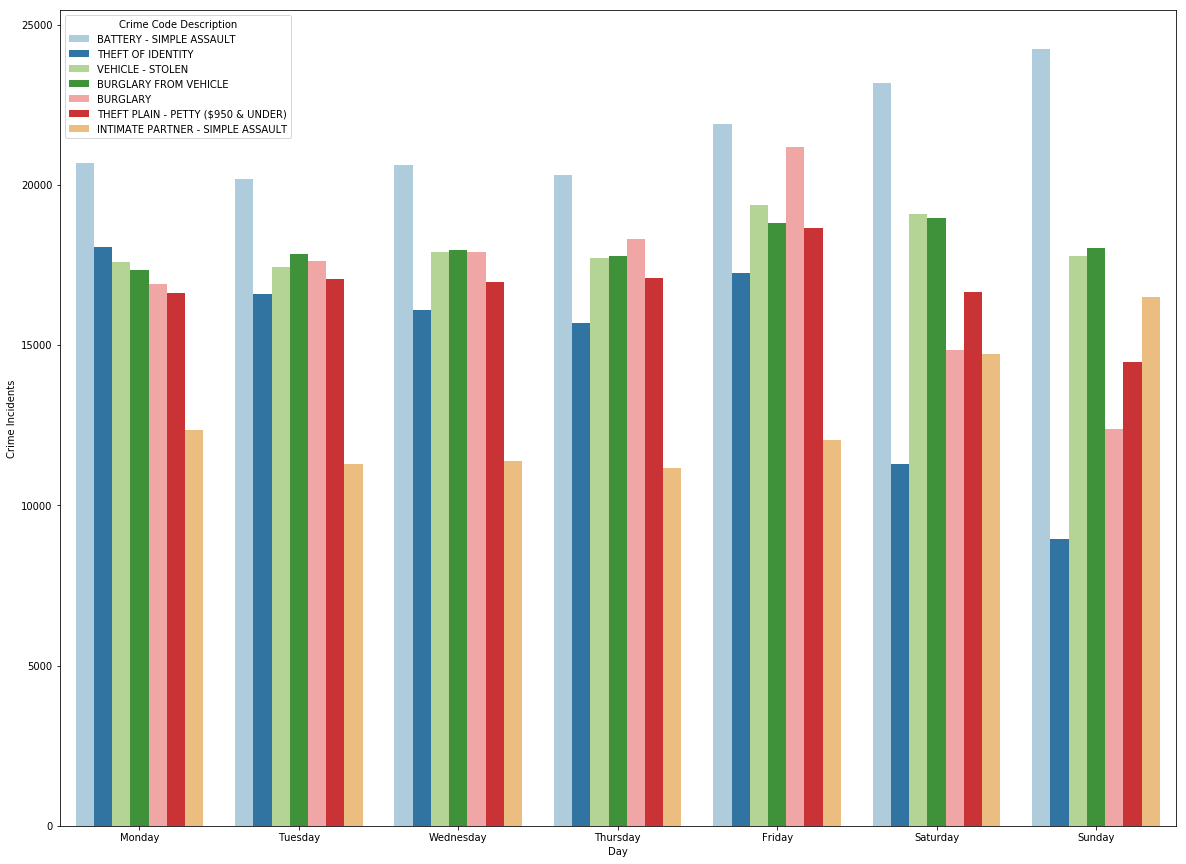

In [17]:
crime_day = crimes.groupby([crimes['Date Occurred'].dt.weekday, crimes['Crime Code'], crimes['Crime Code Description']])
crime_day = pd.DataFrame({'Crime Incidents' : crime_day.size()}).reset_index()


color_palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

crime_day = crime_day.sort_values(by=['Date Occurred', 'Crime Incidents'], ascending=[True, False])
crime_list = crime_day.groupby('Date Occurred').head(5)['Crime Code Description'].unique()

plt.figure(figsize=(20, 15))
ax = sns.barplot( x='Date Occurred', y='Crime Incidents', hue='Crime Code Description',
            data=crime_day[crime_day['Crime Code Description'].isin(crime_list)], palette=color_palette)
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax.set_xlabel('Day');

Remember that we had a peak in crime incidents on friday. We can see that compared to monday until thirsday, the number of incidents for each individual crime is increasing, especially *Burglary* and *Battery-Simple Assault*. The reason that we mentioned initially (people that are going out) might hold, as its possible that there are more bar brawls or something similar on fridays. In case of burglary it one possibility is that as people are more likely to be not at home on friday (evening/night), their empty home might be robbed.

Another interesting observation is, that there are more cases of *Battery-Simple Assault* and *Intimate Partner-Simple Assault* on weekends. On explanation is, that on weekends people might be more likely to be together with their partners at home, which could increase the probability of domestic violence and thus lead to crimes like *Battery-Simple Assault*.

### What crimes happen around 12:00
We previously discover quite a big peak around 12 o'clock, and we now want to know what the reason for this might be.
To do so, we compare the three most common crimes from 10:00 to 14:00 in a grouped bar chart like we did before for each weekday.

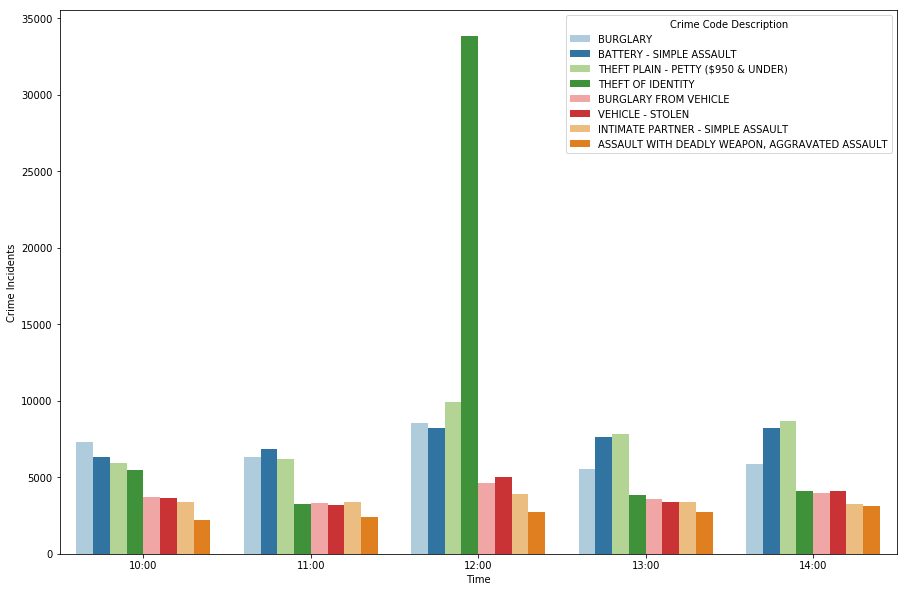

In [54]:
crime_time = crimes.groupby([crimes['Time Occurred'], crimes['Crime Code'], crimes['Crime Code Description']])
crime_time = pd.DataFrame({'Crime Incidents' : crime_time.size()}).reset_index()
crime_time = crime_time.sort_values(by=['Time Occurred','Crime Incidents'], ascending=[True,False])
crime_list = crime_time.groupby('Time Occurred').head(3)['Crime Code Description'].unique()

# color palette from color brewer http://colorbrewer2.org/
color_palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

plt.figure(figsize=(15, 10))

ax = sns.barplot( x='Time Occurred', y='Crime Incidents', hue='Crime Code Description',
            data=crime_time[crime_time['Crime Code Description'].isin(crime_list)&(crime_time['Time Occurred'].isin([1000,1100,1200,1300,1400]))], palette=color_palette)

ax.set_xticklabels(['10:00', '11:00', '12:00', '13:00','14:00'])
ax.set_xlabel('Time');

The obvious outlier at 12:00 is *Theft of Identity* and it seems that this crime is the reason for general peak in the number of crime incidents at 12:00.
However, it does not make too much sense to assign a certain time to this crime, so it might again be the case that 12:00 is some kind of standard value for this kind of crime (and maybe also some others).


### Descent and Crime
Here we want to compare the most common crimes for the ethnical backgrounds *Black, Hispanic/Latino/Mexican, White, Other*, to find out if some crimes are more common for one ethnicity than for another. We will again use a grouped bar chart, however this time we won't use the absolute numbers, but a ratio calculated for each crime within each ethnicity seperately.
E.g. if Whites have a value of 0.5 for the crime *Burglary*, this would mean that 50% of all the crimes where Whites were victims are from the type *Burglary*.

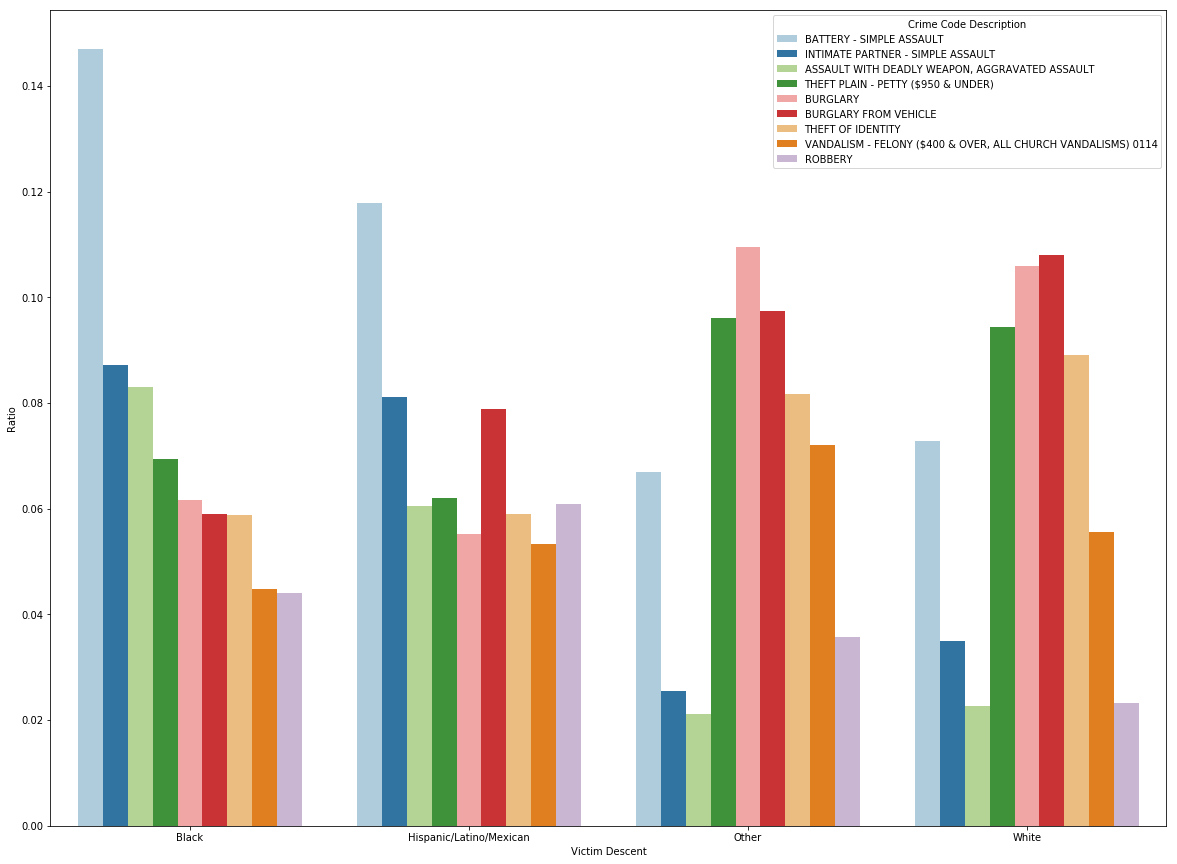

In [206]:
crimes_descent = pd.DataFrame({'Crime Incidents':crimes[crimes['Victim Descent']!='Not Given'].groupby(['Victim Descent','Crime Code Description']).size()}).reset_index()

crimes_descent = crime_descent.sort_values(by=['Victim Descent','Crime Incidents'], ascending=[True,False])
crime_list = crimes_descent[crimes_descent['Victim Descent'].isin(descent)].groupby('Victim Descent').head(3)['Crime Code Description'].unique()

total_incidents = crimes_descent.groupby('Victim Descent')['Crime Incidents'].sum()
crimes_descent['Ratio']=crimes_descent.apply(lambda x: x['Crime Incidents']/total_incidents[x['Victim Descent']], axis=1)

descent = ['H', 'B', 'W', 'O']

# color palette from color brewer http://colorbrewer2.org/
color_palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']


plt.figure(figsize=(20, 15))
ax = sns.barplot( x='Victim Descent', y='Ratio', hue='Crime Code Description',
            data=crimes_descent[crimes_descent['Crime Code Description'].isin(crime_list)&(crimes_descent['Victim Descent'].isin(descent))], palette=color_palette)

ax.set_xticklabels(['Black','Hispanic/Latino/Mexican','Other','White']);

There are quite some differences between the different ethnical backgrounds. Especially when comparing Hispanics and Blacks to Whites with respect to *Battery-Simple Assault*, *Assault with Deadly Weapon* and also *Intimate Partner-Simple Assault*. A reason for this might be found in street gangs. There are several existing gangs in LA, and the most famous ones are probably Bloods (African American and Hispanics) and Crips(mostly African American). But there are probably several other sociological and economical reasons for this.

### Correlation between crime and sex
To see if there is a difference in the crimes males and females are involved, we will compare those two, again by a grouped bar chart.
We think that there might be some differences e.g. in the number of *Intimate Partner-Simple Assault* as women are probably more often victims of domestic violenc than men.
We will again plot the 5 most common crimes for each sex-class and as before for *victim descent*, we use the ratio within each class for comparison.

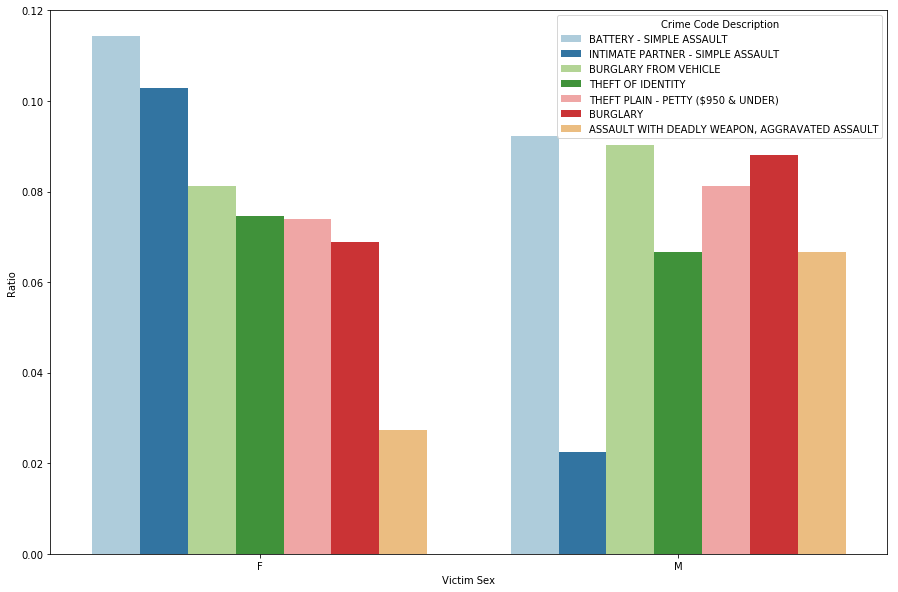

In [182]:
crime_sex =crimes[crimes['Victim Sex'].isin(['M','F'])].groupby([crimes['Victim Sex'], crimes['Crime Code'], crimes['Crime Code Description']])
crime_sex  = pd.DataFrame({'Crime Incidents' : crime_sex .size()}).reset_index()

total_incidents = crime_sex.groupby('Victim Sex')['Crime Incidents'].sum()
crime_sex['Ratio']=crime_sex.apply(lambda x: x['Crime Incidents']/total_incidents[x['Victim Sex']], axis=1)

crime_sex = crime_sex.sort_values(by=['Victim Sex','Ratio'],ascending=[True, False])

crime_list = crime_sex.groupby('Victim Sex').head(5)['Crime Code Description'].unique()

color_palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

plt.figure(figsize=(15, 10))
ax = sns.barplot( x='Victim Sex', y='Ratio', hue='Crime Code Description',
            data=crime_sex[crime_sex['Crime Code Description'].isin(crime_list)], palette=color_palette)

Our assumption seems to be correct, females tend to be more often victims of *Intimate Partner-Simple Assault*. Its also interesting that males seem to be more often the victims of burglary (plain as well as vehicle). An explanation for this could be, that in case of married people who own a house or a car, the man might be the one who will report the crime and will  thus be seen as the victim.
Another major difference is between the ratios for *Assault with deadly weapon*, which might be correlated to the fact that males are  usually more involved in street gangs/gang fights than females. Therefore they are more likely to encounter such violence.

### We want to now who is more often the victim of a homicide in terms of sex and age
In total we have 2242 homicde cases, exluding cases include victims where the sex is for unknown or not given. What we now want to know is, how homicide victims are related with respect to age and sex


In [166]:
homicide_victims = crimes[(crimes['Crime Code'] == 110.0)&(crimes['Victim Sex']!='X')&(crimes['Victim Sex']!='Not Given')].copy()

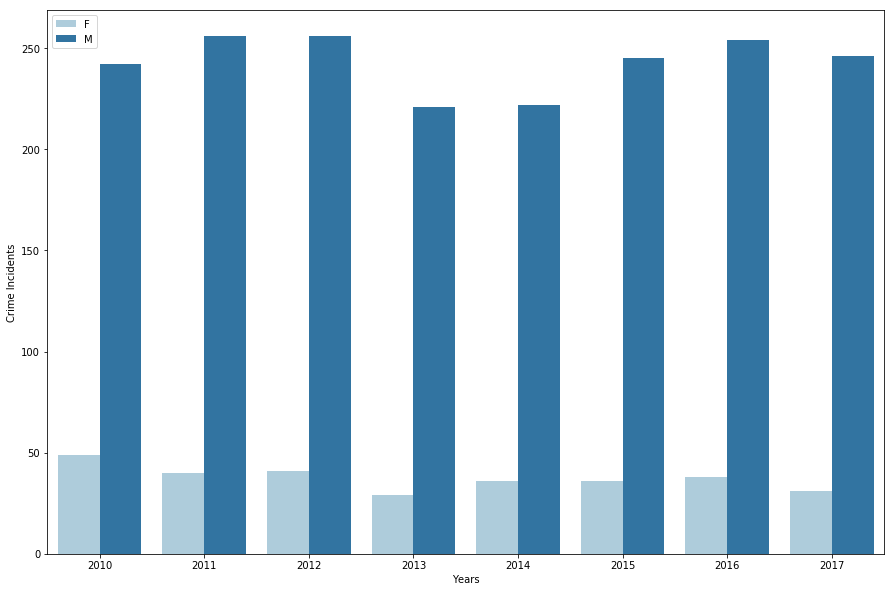

In [279]:
grouped = homicide_victims.groupby([homicide_victims['Date Occurred'].dt.year, homicide_victims['Victim Sex']])
grouped = pd.DataFrame({'Crime Incidents' :  grouped.size()}).reset_index()

years = homicide_victims['Date Occurred'].dt.year.unique()
years.sort()

plt.figure(figsize=(15, 10))

ax = sns.barplot(x="Date Occurred", y="Crime Incidents", hue="Victim Sex", data=grouped[grouped['Victim Sex'].isin(['M','F'])], palette=['#a6cee3','#1f78b4'])
ax.set_xlabel("Years");

plt.legend(loc='upper left');

The absolute number of males that are victims of a homicide is about 5-6 times higher each year, however the overall number of males that are victims of any crime is not 6 times higher than that of females.
It therefore seems that males are just more likely to be the victim of a crime, which could have several reasons.
Due to hormones like testosterone, males (especially younger ones) tend to be more aggressive and thus might be more often involved in some sort of fighting, which could eventually lead to their killing. And as mentioned before, gang fights could also play a role.

With the following plot we want to show the age distribution of homicide victims partitioned by their sex (in relative terms). In order to do this we use a two (opaque) overlapping histograms, one for males and one for females.

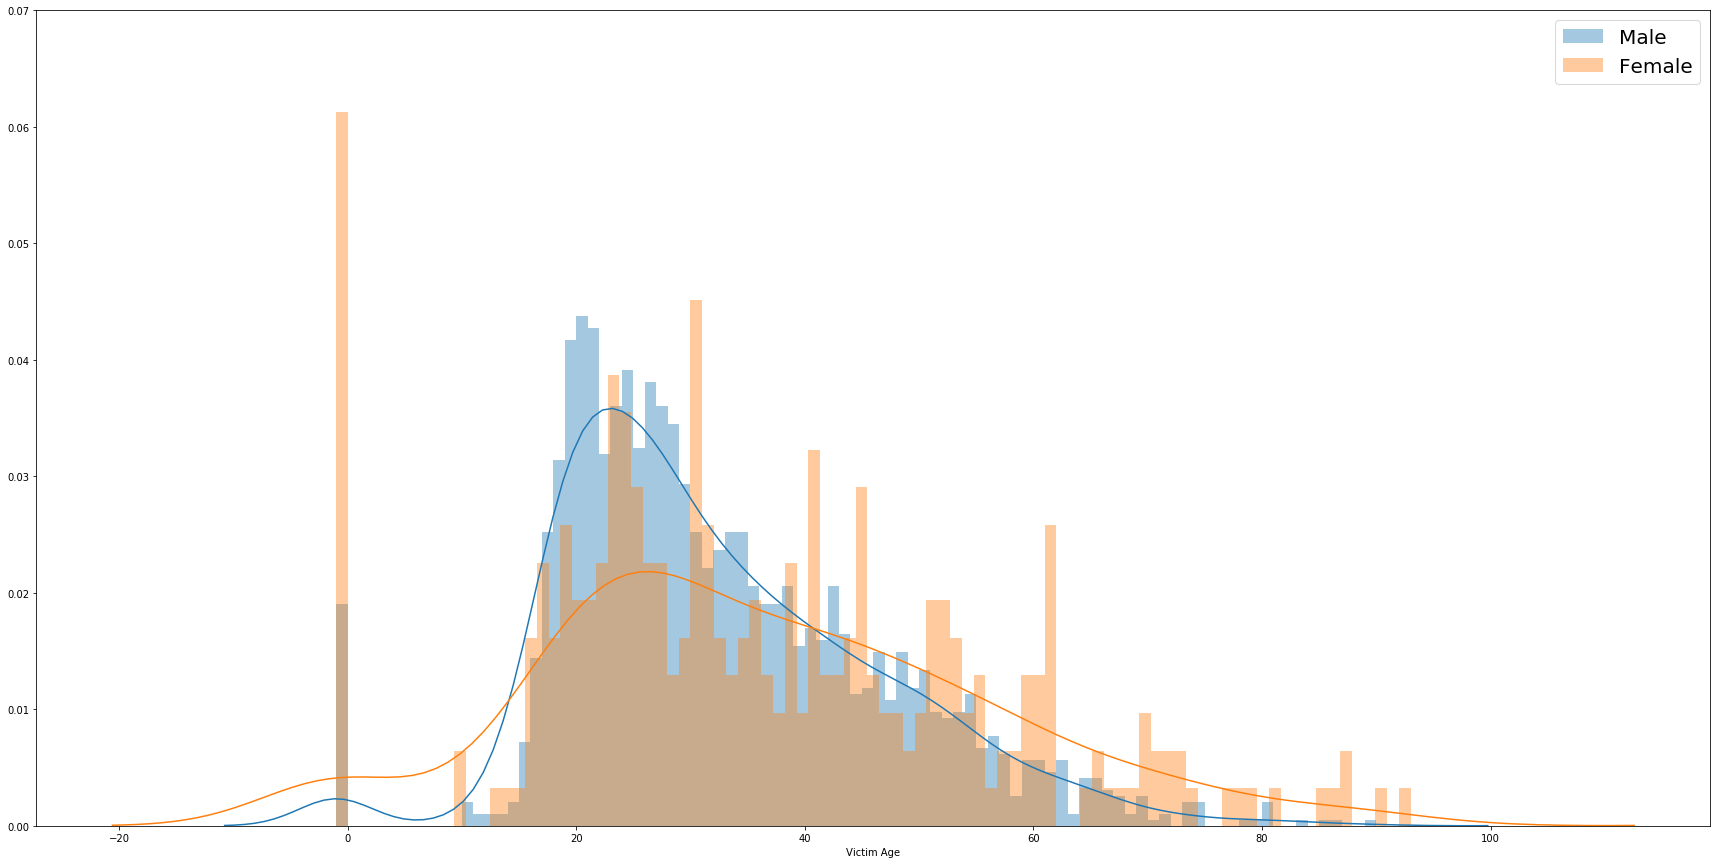

In [277]:
homicide_age = pd.DataFrame({'crime Indicents':homicide_victims.groupby('Victim Age').size()})
data = [go.Histogram(x=homicide_victims[homicide_victims['Victim Sex']=='F']['Victim Age'])]

fig, ax = plt.subplots(figsize=(30,15))
sns.distplot(homicide_victims[homicide_victims['Victim Sex']=='M']['Victim Age'], bins=91, ax=ax, label='Male')
sns.distplot(homicide_victims[homicide_victims['Victim Sex']=='F']['Victim Age'], bins=91, ax=ax, label='Female')
ax.legend(prop={'size': 20})
ax.set_ylim([0, 0.07]);

Two major differences are observable. First, disregarding the age value -1, we can see that the maximums are slightly shifted. In relative terms, it seems that more young males around the age of 20 are victims of homicide compared to females where the maximums is closer to 25 respectively approx. 31. This could be inline with our 'street gang' explanation.
The second difference is, that there seem to be more female homicide victims without a given age (again in relative terms). We can again only guess what reasons there might be, but a probably far-fetched explanation could be that those vicitms were prostitutes without any ID-card, so they couldn't determine the age.


## Clustering

In [ ]:
# crimes.to_pickle('cleaned_crime_dump')
# crimes = pd.read_pickle('cleaned_crime_dump')

## Description of how the required elements of the task description are fulfilled